In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.5, 0.5],
    c1 = 2.0,
    c2 = 2.0,
    w = 1.2,
    w_decay = 0.95,
    scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8580246913580247, Loss: 0.5816918125859013
Checkpoint 200, Accuracy: 0.8641975308641975, Loss: 0.5796992690474899
Checkpoint 300, Accuracy: 0.8395061728395061, Loss: 0.579975340101454
Checkpoint 400, Accuracy: 0.8641975308641975, Loss: 0.584692778410735
Checkpoint 500, Accuracy: 0.8703703703703703, Loss: 0.5625871728967737


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None and title is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

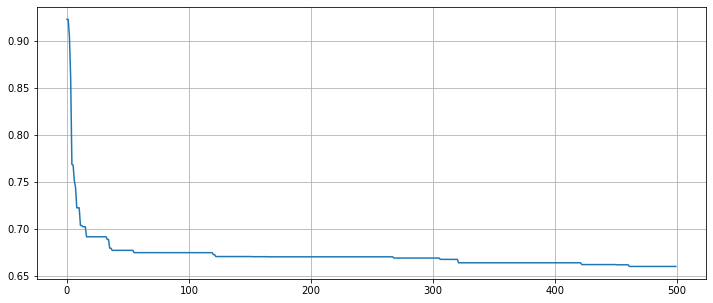

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.8205912 ]
 [0.16126782]
 [0.01814089]]
[0. 1. 0.] <-> [[0.7244936 ]
 [0.22914346]
 [0.04636297]]
[1. 0. 0.] <-> [[0.69909173]
 [0.23682812]
 [0.06408016]]
[1. 0. 0.] <-> [[0.4926558 ]
 [0.28368738]
 [0.22365683]]
[0. 0. 1.] <-> [[0.08194968]
 [0.5061812 ]
 [0.4118691 ]]
[1. 0. 0.] <-> [[0.77592045]
 [0.2017694 ]
 [0.02231019]]
[1. 0. 0.] <-> [[0.80577093]
 [0.17624602]
 [0.01798302]]
[1. 0. 0.] <-> [[0.90547097]
 [0.04256862]
 [0.05196043]]
[1. 0. 0.] <-> [[0.7708165 ]
 [0.205382  ]
 [0.02380155]]
[1. 0. 0.] <-> [[0.7679805 ]
 [0.20729388]
 [0.0247256 ]]
[0. 1. 0.] <-> [[0.43372887]
 [0.31901085]
 [0.24726033]]
[1. 0. 0.] <-> [[0.53840566]
 [0.25981903]
 [0.20177537]]
[1. 0. 0.] <-> [[0.80903625]
 [0.17304927]
 [0.0179145 ]]
[1. 0. 0.] <-> [[0.82830673]
 [0.15306427]
 [0.01862889]]
[1. 0. 0.] <-> [[0.8754528 ]
 [0.09783845]
 [0.02670873]]
[1. 0. 0.] <-> [[0.4764079 ]
 [0.29346198]
 [0.23013014]]
[1. 0. 0.] <-> [[0.8750349 ]
 [0.09838164]
 [0.02658351]]
[0. 1. 0.] <->

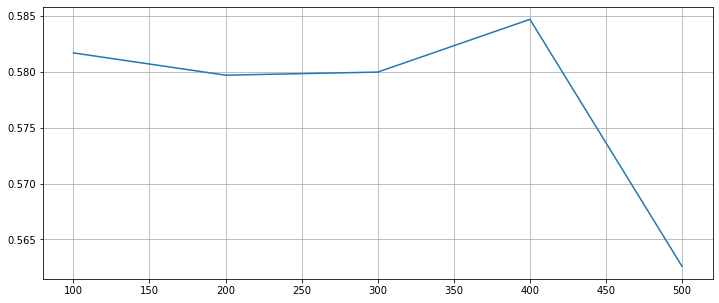

In [12]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

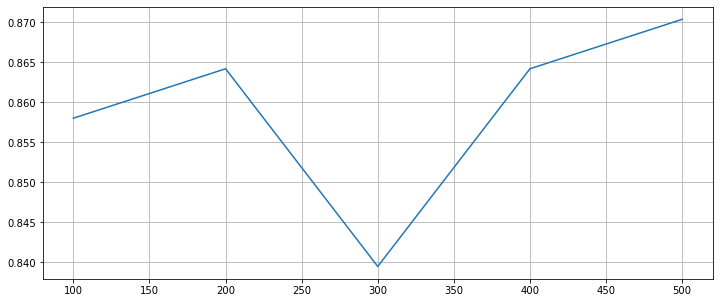

In [13]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[[ 0.5122143 ]
 [-1.9126666 ]
 [ 1.284669  ]
 [ 0.27030054]
 [ 0.8074376 ]]
 bias: [-3.]

Neuron 1: weights:
[[ 0.3392557 ]
 [ 0.13182898]
 [-0.03215371]
 [-0.17168641]
 [-1.5047177 ]]
 bias: [3.]

Neuron 2: weights:
[[ 2.237485 ]
 [ 3.       ]
 [-1.173228 ]
 [ 0.8170087]
 [ 3.       ]]
 bias: [0.16976817]

Neuron 3: weights:
[[-0.03587858]
 [-1.2806555 ]
 [ 1.471204  ]
 [-0.58462185]
 [ 3.        ]]
 bias: [2.7823222]

$
Layer 2
Neuron 0: weights:
[[ 0.9320715 ]
 [ 3.        ]
 [-0.02012047]
 [-0.8773663 ]]
 bias: [-0.29424828]

Neuron 1: weights:
[[ 0.54820377]
 [-1.2998194 ]
 [ 0.2742856 ]
 [ 1.297649  ]]
 bias: [0.533011]

Neuron 2: weights:
[[ 3.        ]
 [ 0.28956515]
 [ 3.        ]
 [-2.63741   ]]
 bias: [-0.1618259]

$

